In [42]:
library(tidyverse)
library(readxl)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
library(cowplot)

In [43]:
set.seed(19)
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
download.file(url, "credit_default.xls")
cd <- read_excel("credit_default.xls", skip = 1)
head(cd)

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,⋯,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,20000,2,2,1,24,2,2,-1,-1,⋯,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,⋯,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,⋯,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,⋯,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,⋯,20940,19146,19131,2000,36681,10000,9000,689,679,0
6,50000,1,1,2,37,0,0,0,0,⋯,19394,19619,20024,2500,1815,657,1000,1000,800,0


In [44]:
colnames(cd) <- make.names(colnames(cd))
head(cd)

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,⋯,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,20000,2,2,1,24,2,2,-1,-1,⋯,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,⋯,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,⋯,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,⋯,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,⋯,20940,19146,19131,2000,36681,10000,9000,689,679,0
6,50000,1,1,2,37,0,0,0,0,⋯,19394,19619,20024,2500,1815,657,1000,1000,800,0


In [45]:
cd_university <- cd %>%
filter(EDUCATION == 2)
#cd_university
nrow(cd_university)

[1] 14030

In [48]:
rows <- sample(nrow(cd_university))
df <- cd_university[rows, ]

cd_5000_init <- slice(df, 1:5000) %>%
        rename(default_nm = default.payment.next.month) %>%
        mutate(default_nm = as_factor(default_nm)) %>%
        mutate(pay_avg = (PAY_AMT1 + PAY_AMT2 + PAY_AMT3 + PAY_AMT4 + PAY_AMT5 + PAY_AMT6)/6) %>%
        mutate(bill_avg = (BILL_AMT1 + BILL_AMT2 + BILL_AMT3 + BILL_AMT4 + BILL_AMT5 + BILL_AMT6))
head(cd_5000_init)

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,⋯,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_nm,pay_avg,bill_avg
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
29668,110000,1,2,2,38,3,2,2,0,⋯,42727,4000,0,2000,1500,2000,2000,1,1916.667,366421
11308,260000,1,2,1,38,-1,-1,-1,-1,⋯,1441,5722,28811,1313,2667,1447,2588,0,7091.333,57613
26111,80000,2,2,1,38,-2,-2,-2,-2,⋯,390,0,0,0,0,390,0,0,65.000,390
16202,400000,2,2,1,43,0,0,0,0,⋯,201699,17000,7000,7000,7000,11000,10000,0,9833.333,1577966
28916,50000,2,2,1,34,0,0,0,0,⋯,1655,1023,1051,1000,50,10050,734,0,2318.000,20709
18255,80000,1,2,1,52,0,0,0,0,⋯,23396,3500,2202,1500,1500,1500,1500,0,1950.333,296203


In [49]:
cd_split <- initial_split(cd_5000_init, prop=0.75, strata=default_nm)
cd_training <- training(cd_split)
cd_testing <- testing(cd_split)

In [50]:
cd_5000 <- cd_training %>%
        mutate(payment_to_bill_ratio = pay_avg/bill_avg) %>%     
        mutate(usage_cdt = bill_avg/LIMIT_BAL) %>% # to see how much of their balance they use 
        mutate(pmt = pay_avg/LIMIT_BAL) %>% # to see how much of their balance they pay
        mutate(diff_usage_pmt = usage_cdt - pmt)
head(cd_5000)
d1 <- filter(cd_5000, default_nm == 1)

d0 <- filter(cd_5000, default_nm ==0)

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,⋯,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_nm,pay_avg,bill_avg,payment_to_bill_ratio,usage_cdt,pmt,diff_usage_pmt
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
29668,110000,1,2,2,38,3,2,2,0,⋯,1500,2000,2000,1,1916.667,366421,0.005230777,3.331100,0.01742424,3.3136758
26111,80000,2,2,1,38,-2,-2,-2,-2,⋯,0,390,0,0,65.000,390,0.166666667,0.004875,0.00081250,0.0040625
16202,400000,2,2,1,43,0,0,0,0,⋯,7000,11000,10000,0,9833.333,1577966,0.006231651,3.944915,0.02458333,3.9203317
28916,50000,2,2,1,34,0,0,0,0,⋯,50,10050,734,0,2318.000,20709,0.111932010,0.414180,0.04636000,0.3678200
18255,80000,1,2,1,52,0,0,0,0,⋯,1500,1500,1500,0,1950.333,296203,0.006584448,3.702538,0.02437917,3.6781583
14728,110000,2,2,1,46,0,0,0,0,⋯,3975,4162,3945,1,3995.000,665745,0.006000796,6.052227,0.03631818,6.0159091


In [113]:
cd_5000_means <- cd_5000 %>%
                group_by(default_nm) %>%
                summarize(n = n(),
                         mean_pay0 = mean(PAY_0, na.rm = TRUE),
                         mean_limit = mean(LIMIT_BAL, na.rm = TRUE),
                         mean_bill = mean(bill_avg, na.rm = TRUE),
                         mean_pay = mean(pay_avg, na.rm = TRUE),
                         mean_usage_cdt = mean(usage_cdt, na.rm = TRUE),
                         mean_pmt = mean(pmt, na.rm = TRUE),
                         mean_diff_usage_pmt = mean(diff_usage_pmt, na.rm = TRUE)
                         )
cd_5000_means

`summarise()` ungrouping output (override with `.groups` argument)



default_nm,n,mean_pay0,mean_limit,mean_bill,mean_pay,mean_usage_cdt,mean_pmt,mean_diff_usage_pmt
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2849,-0.1077571,154152.3,279699.5,5160.686,2.461240,0.04171543,2.419525
1,902,0.7549889,114013.3,263949.7,3090.172,2.987018,0.03556567,2.951452


In [114]:
# Now let's take a look at some of the columns we created 
cd_5000_select <- cd_5000 %>%
                select(LIMIT_BAL, PAY_0, bill_avg, pay_avg, usage_cdt, pmt, diff_usage_pmt, default_nm)
head(cd_5000_select) 

LIMIT_BAL,PAY_0,bill_avg,pay_avg,usage_cdt,pmt,diff_usage_pmt,default_nm
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
110000,3,366421,1916.667,3.331100,0.01742424,3.3136758,1
80000,-2,390,65.000,0.004875,0.00081250,0.0040625,0
400000,0,1577966,9833.333,3.944915,0.02458333,3.9203317,0
50000,0,20709,2318.000,0.414180,0.04636000,0.3678200,0
80000,0,296203,1950.333,3.702538,0.02437917,3.6781583,0
110000,0,665745,3995.000,6.052227,0.03631818,6.0159091,1


In [116]:
bill_is_0 <- filter(cd_5000_select, bill_avg == 0)
head(bill_is_0)
pay_is_0 <- filter(cd_5000_select, pay_avg == 0)
head(pay_is_0)

LIMIT_BAL,PAY_0,bill_avg,pay_avg,usage_cdt,pmt,diff_usage_pmt,default_nm
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
210000,1,0,0.0000,0,0.000000000,0.000000000,0
20000,1,0,0.0000,0,0.000000000,0.000000000,1
30000,1,0,0.0000,0,0.000000000,0.000000000,0
210000,-2,0,0.0000,0,0.000000000,0.000000000,0
190000,-2,0,0.0000,0,0.000000000,0.000000000,0
390000,1,0,661.8333,0,0.001697009,-0.001697009,1


LIMIT_BAL,PAY_0,bill_avg,pay_avg,usage_cdt,pmt,diff_usage_pmt,default_nm
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
210000,1,0,0,0.000,0,0.000,0
20000,1,0,0,0.000,0,0.000,1
30000,1,0,0,0.000,0,0.000,0
210000,-2,0,0,0.000,0,0.000,0
190000,-2,0,0,0.000,0,0.000,0
20000,2,9900,0,0.495,0,0.495,1


In [99]:
payment_to_bill_arranged <- cd_5000_select %>%
                        arrange(payment_to_bill_ratio) # NaN's and infs are because of payment/bill where bill is 0 
head(payment_to_bill_arranged)

LIMIT_BAL,PAY_0,bill_avg,pay_avg,usage_cdt,pmt,payment_to_bill_ratio,diff_usage_pmt,default_nm
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
50000,1,-8,500.6667,-0.000160000,0.0100133333,-62.5833333,-0.010173333,0
90000,1,-746,721.6667,-0.008288889,0.0080185185,-0.9673816,-0.016307407,0
60000,1,-566,491.6667,-0.009433333,0.0081944444,-0.8686690,-0.017627778,0
300000,1,-301,226.1667,-0.001003333,0.0007538889,-0.7513843,-0.001757222,0
360000,1,-1410,916.6667,-0.003916667,0.0025462963,-0.6501182,-0.006462963,0
130000,1,-312,166.6667,-0.002400000,0.0012820513,-0.5341880,-0.003682051,1


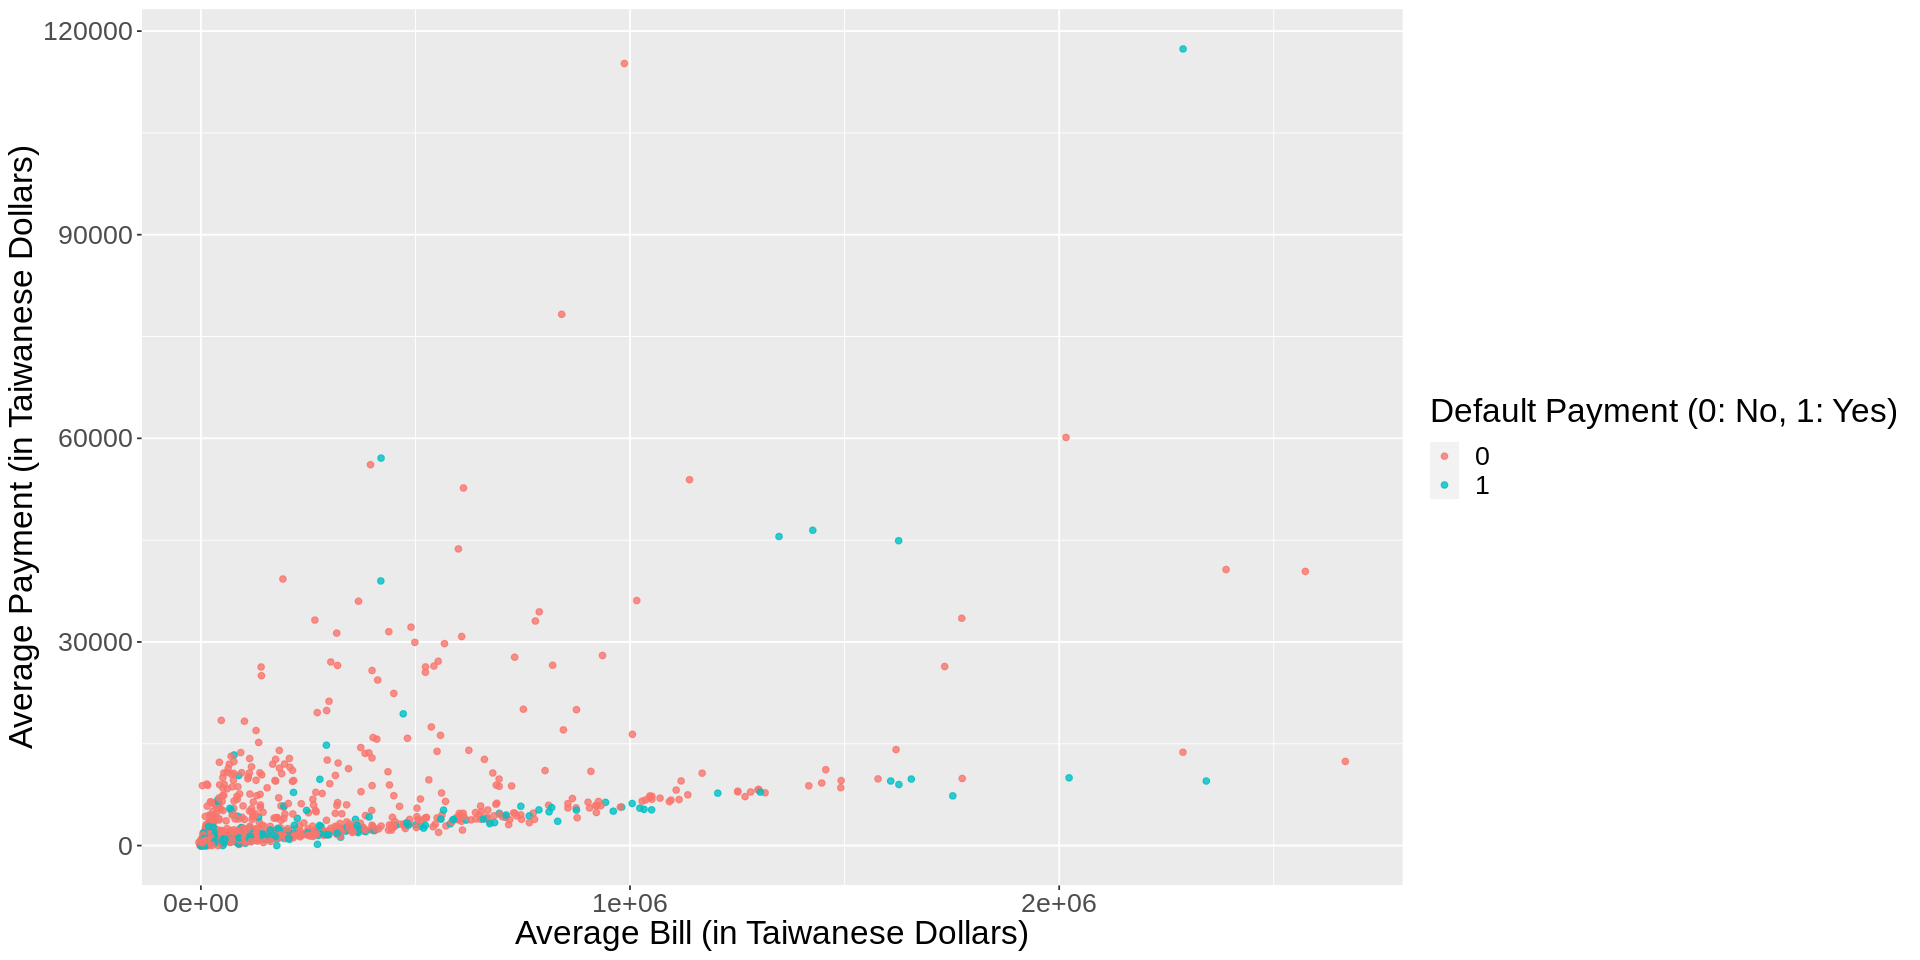

In [73]:
options(repr.plot.width = 16, repr.plot.height = 8)
pay_bill_plot <- cd_5000_select %>%
                slice(1:1000) %>%
                ggplot(aes(x = bill_avg, y = pay_avg, color = default_nm))+
                geom_point(alpha = 0.8)+
                labs(x = "Average Bill (in Taiwanese Dollars)", y = "Average Payment (in Taiwanese Dollars)", color = "Default Payment (0: No, 1: Yes)")+
                theme(text = element_text(size = 20))
pay_bill_plot

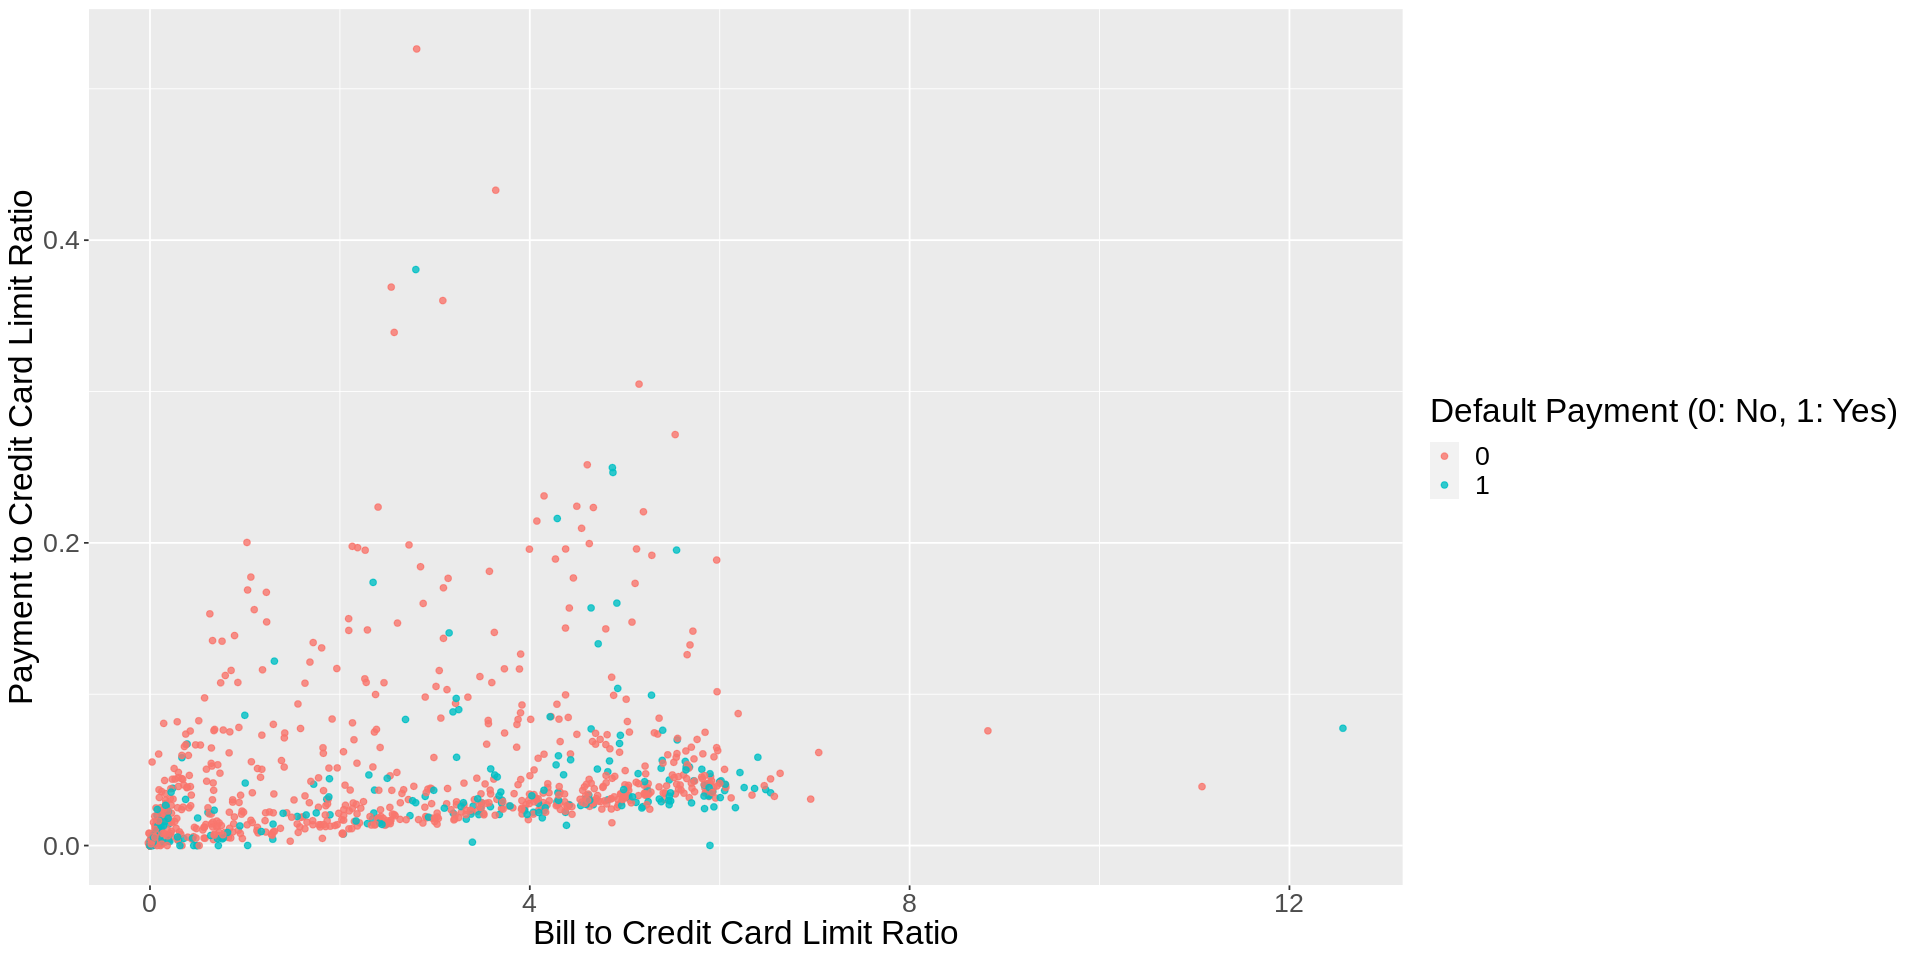

In [89]:
options(repr.plot.width = 16, repr.plot.height = 8)
pay_bill_plot <- cd_5000_select %>%
                slice(1:1000) %>%
                ggplot(aes(x = usage_cdt, y = pmt, color = default_nm))+
                geom_point(alpha = 0.8)+
                labs(x = "Bill to Credit Card Limit Ratio", y = "Payment to Credit Card Limit Ratio", color = "Default Payment (0: No, 1: Yes)")+
                theme(text = element_text(size = 20))
pay_bill_plot

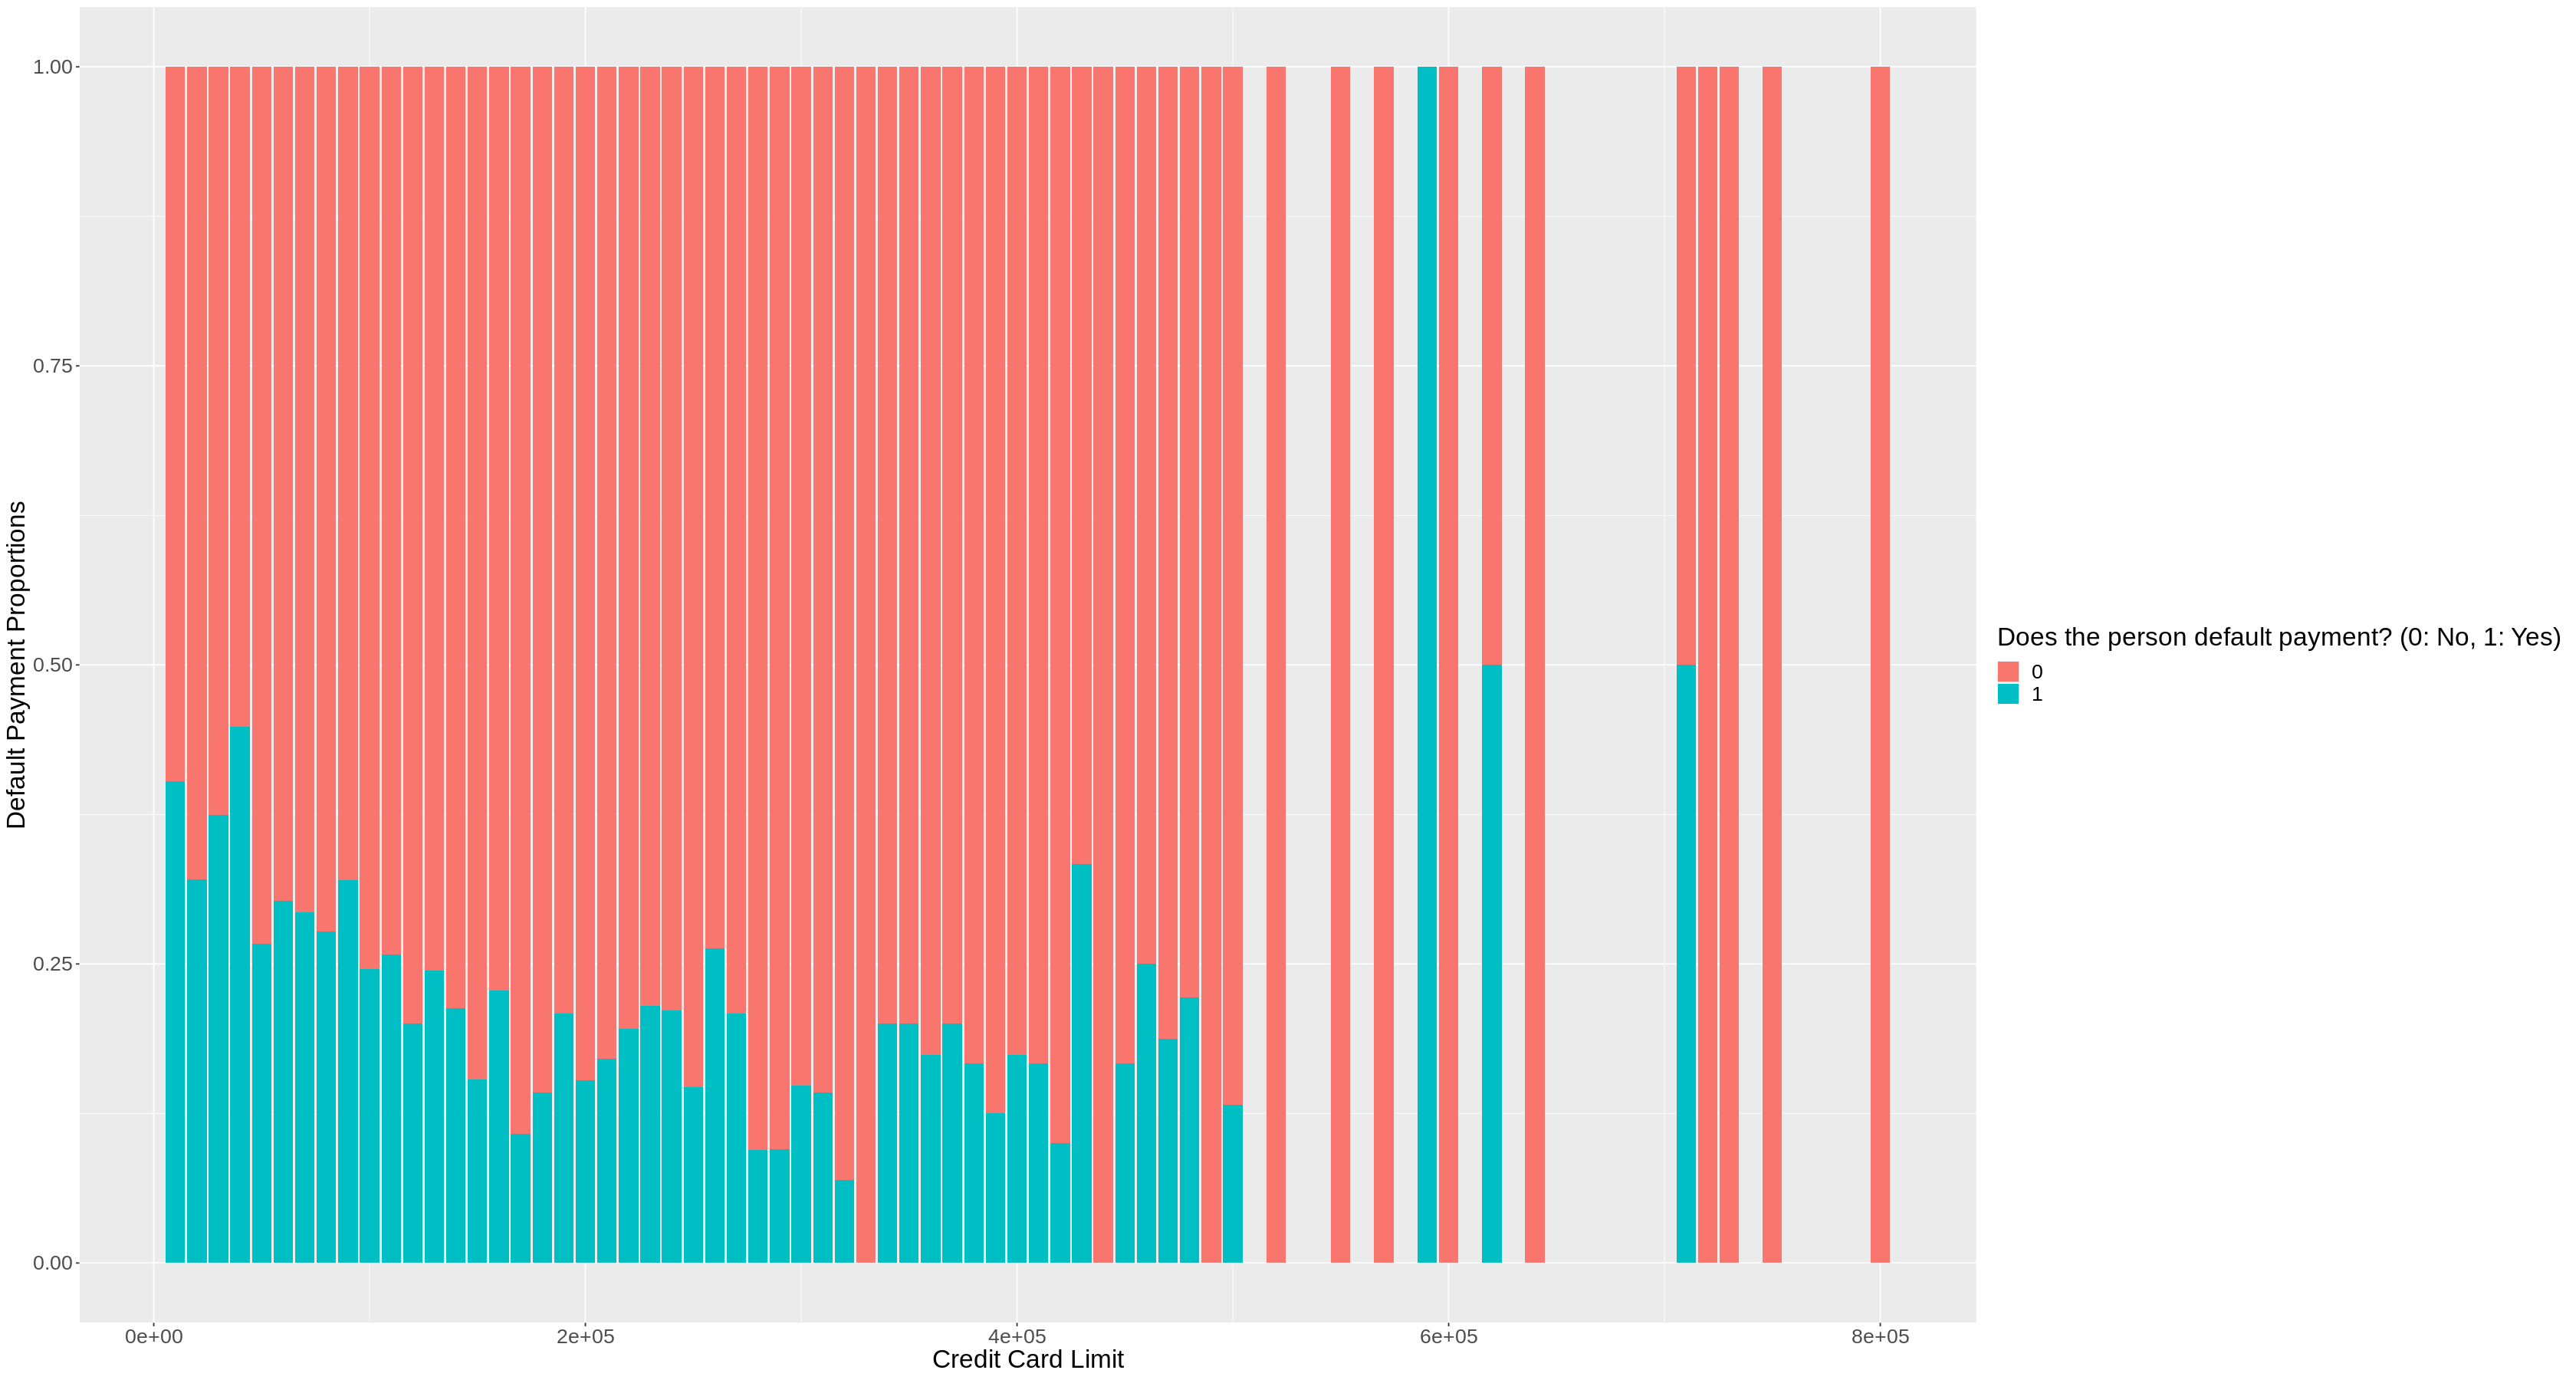

In [84]:
options(repr.plot.width = 28, repr.plot.height = 15)
bar_plot <- cd_5000_select %>%
   ggplot(aes(x = LIMIT_BAL, fill = default_nm)) + 
   geom_bar(position = 'fill') + 
   xlab("Credit Card Limit") +
   ylab("Default Payment Proportions") +
   labs(fill = "Does the person default payment? (0: No, 1: Yes)")+
   theme(text = element_text(size = 20))
bar_plot

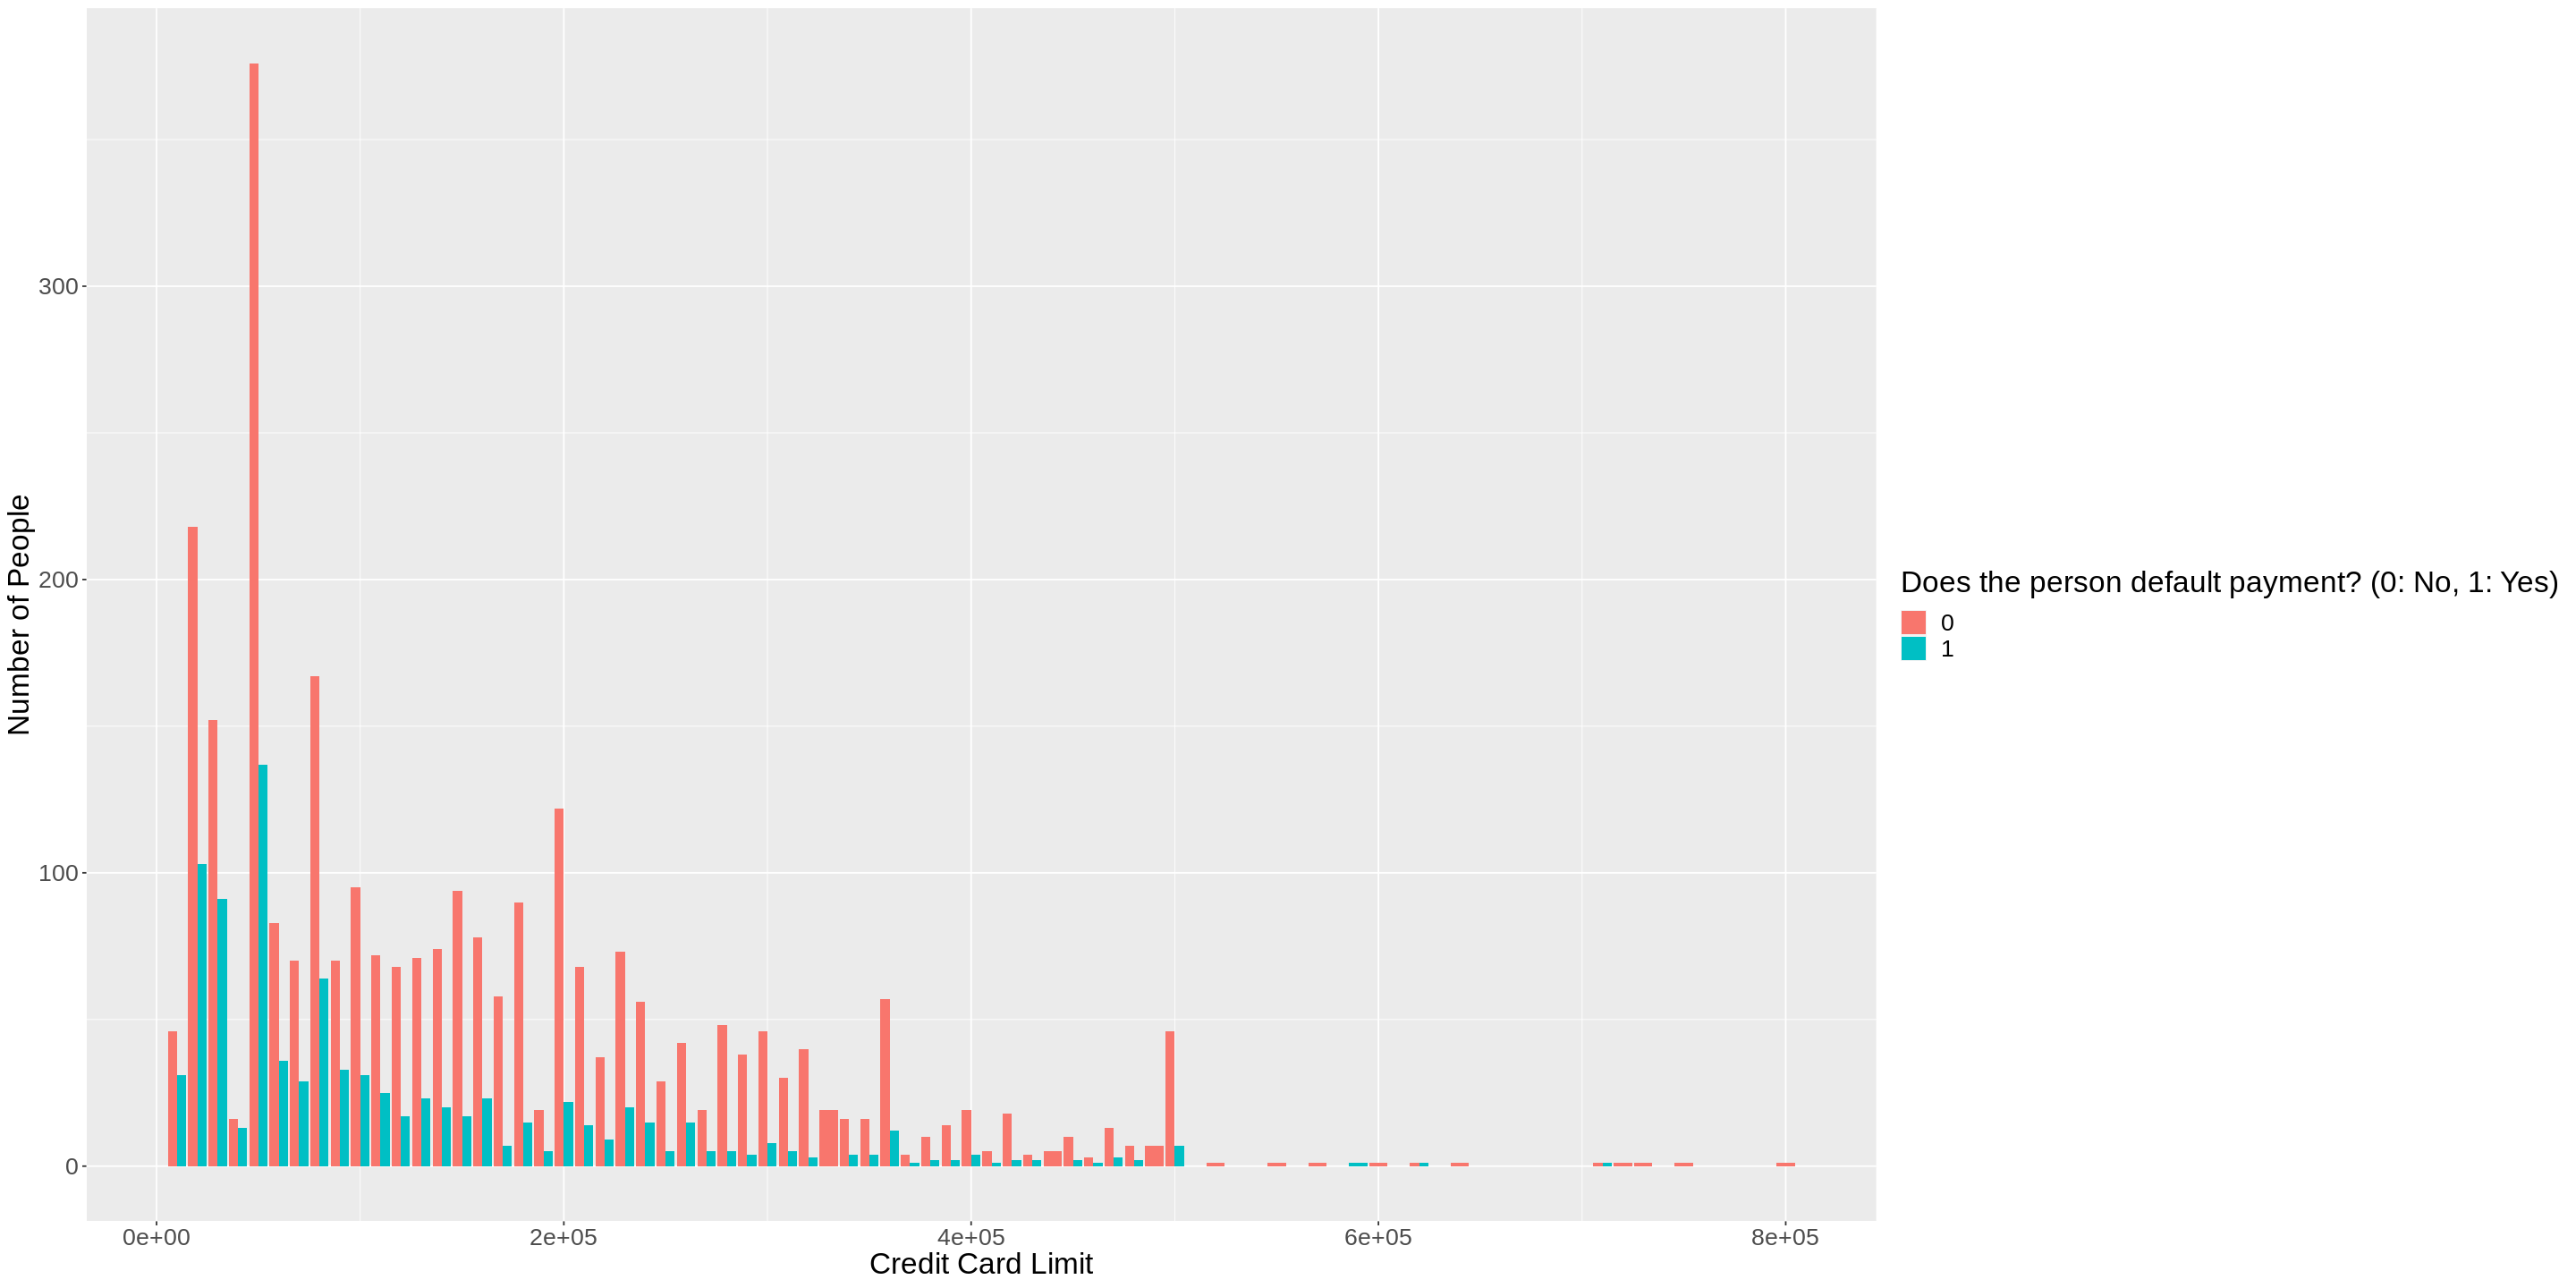

In [86]:
options(repr.plot.width = 24, repr.plot.height = 12)
bar_plot <- cd_5000 %>%
   ggplot(aes(x = LIMIT_BAL, fill = default_nm)) + 
   geom_bar(position = 'dodge') + 
   xlab("Credit Card Limit") +
   ylab("Number of People") +
   labs(fill = "Does the person default payment? (0: No, 1: Yes)")+
   theme(text = element_text(size = 20))
bar_plot

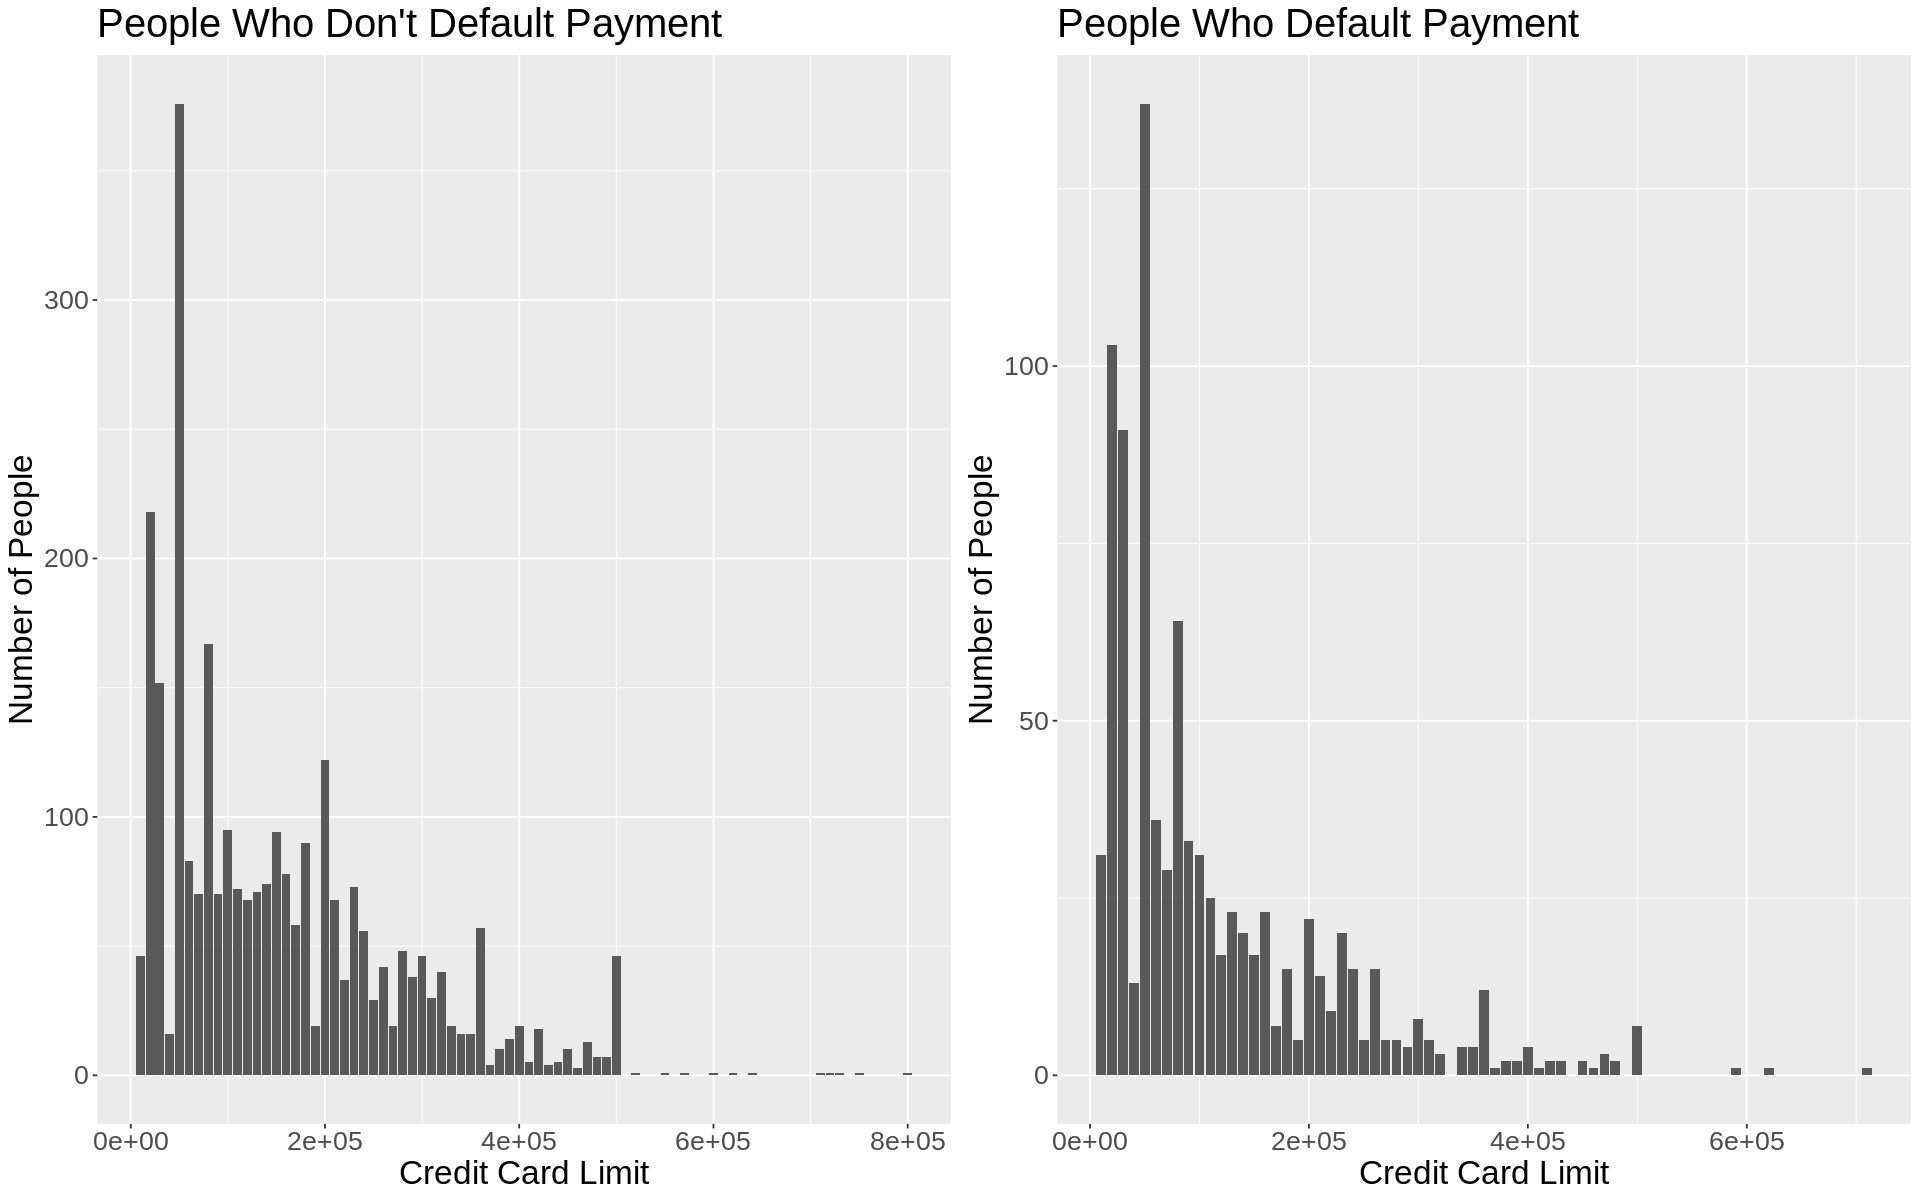

In [88]:
options(repr.plot.width = 16, repr.plot.height = 10)

d1_bal <- d1 %>%
ggplot(aes(x=LIMIT_BAL)) +
geom_bar() +
ggtitle("People Who Default Payment") +
labs(x = "Credit Card Limit", y = "Number of People")+
theme(text = element_text(size = 20))

d0_bal <- d0 %>%
ggplot(aes(x=LIMIT_BAL)) +
geom_bar() +
ggtitle("People Who Don't Default Payment") +
labs(x = "Credit Card Limit", y = "Number of People")+
theme(text = element_text(size = 20))

plot_grid(d0_bal, d1_bal)

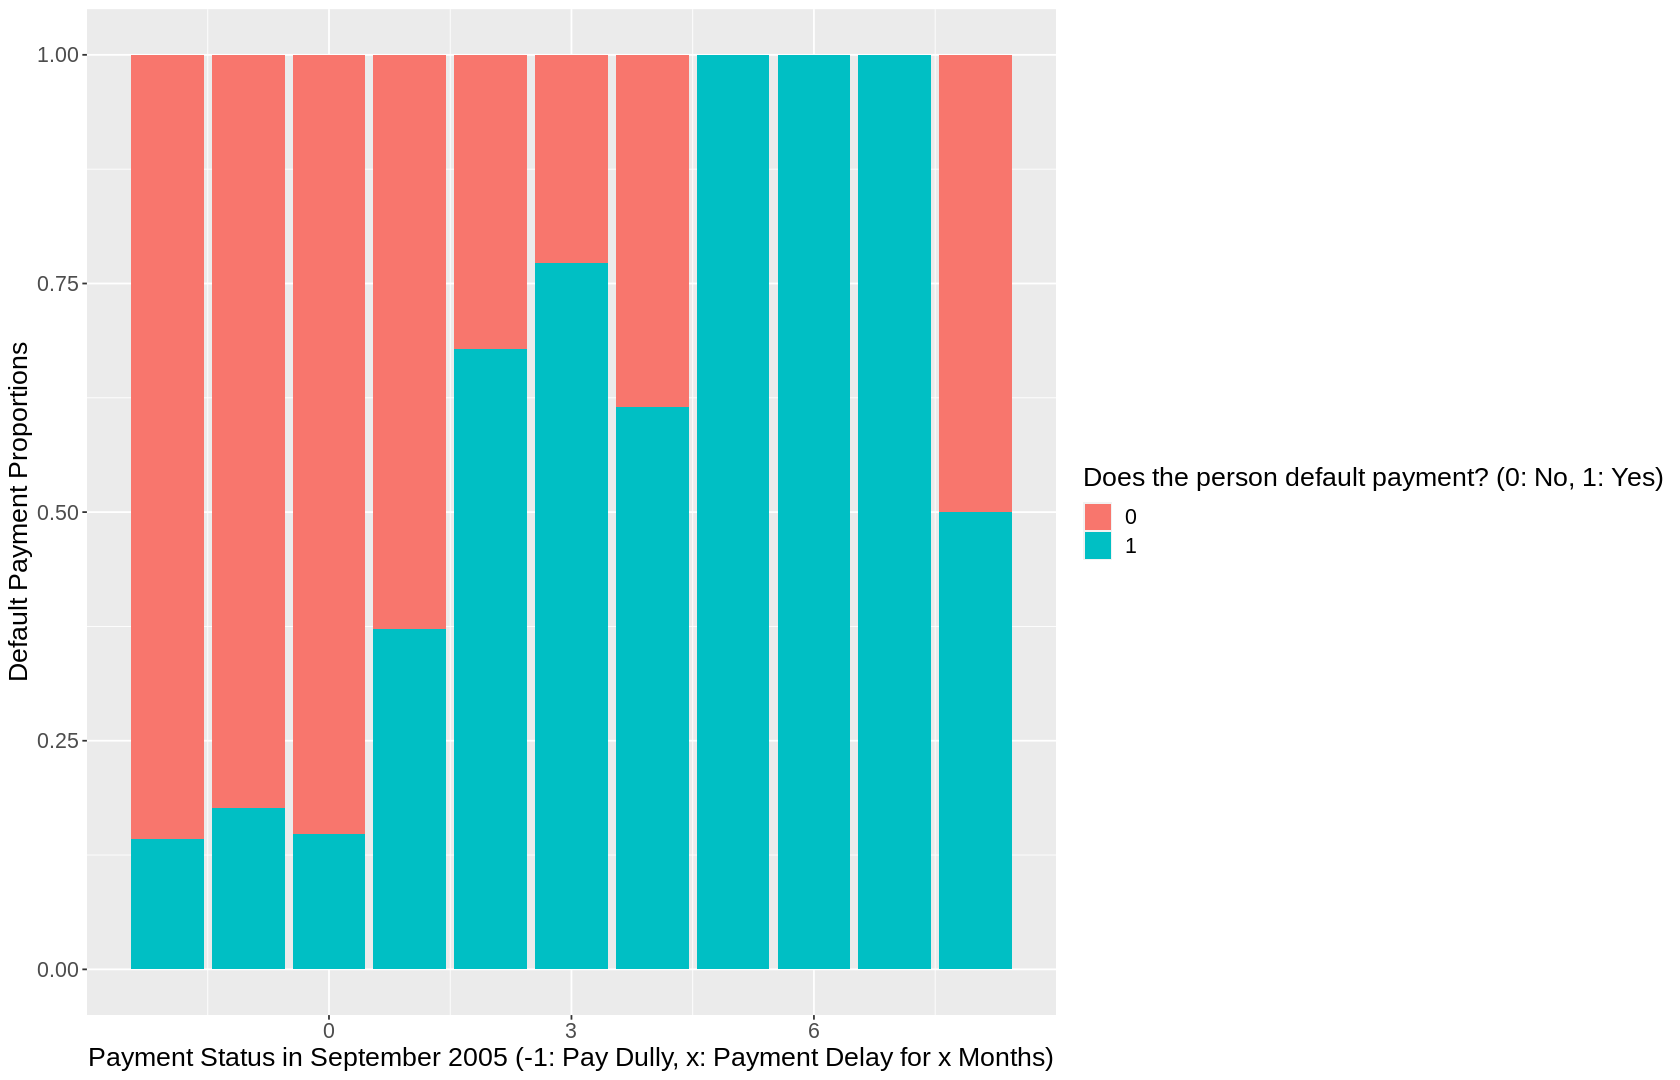

In [117]:
options(repr.plot.width = 14, repr.plot.height = 9)
bar_plot1 <- cd_5000_select %>%
   ggplot(aes(x = PAY_0, fill = default_nm)) + 
   geom_bar(position = 'fill') + 
   xlab("Payment Status in September 2005 (-1: Pay Dully, x: Payment Delay for x Months)") +
   ylab("Default Payment Proportions") +
   labs(fill = "Does the person default payment? (0: No, 1: Yes)")+
   theme(text = element_text(size = 16))
bar_plot1

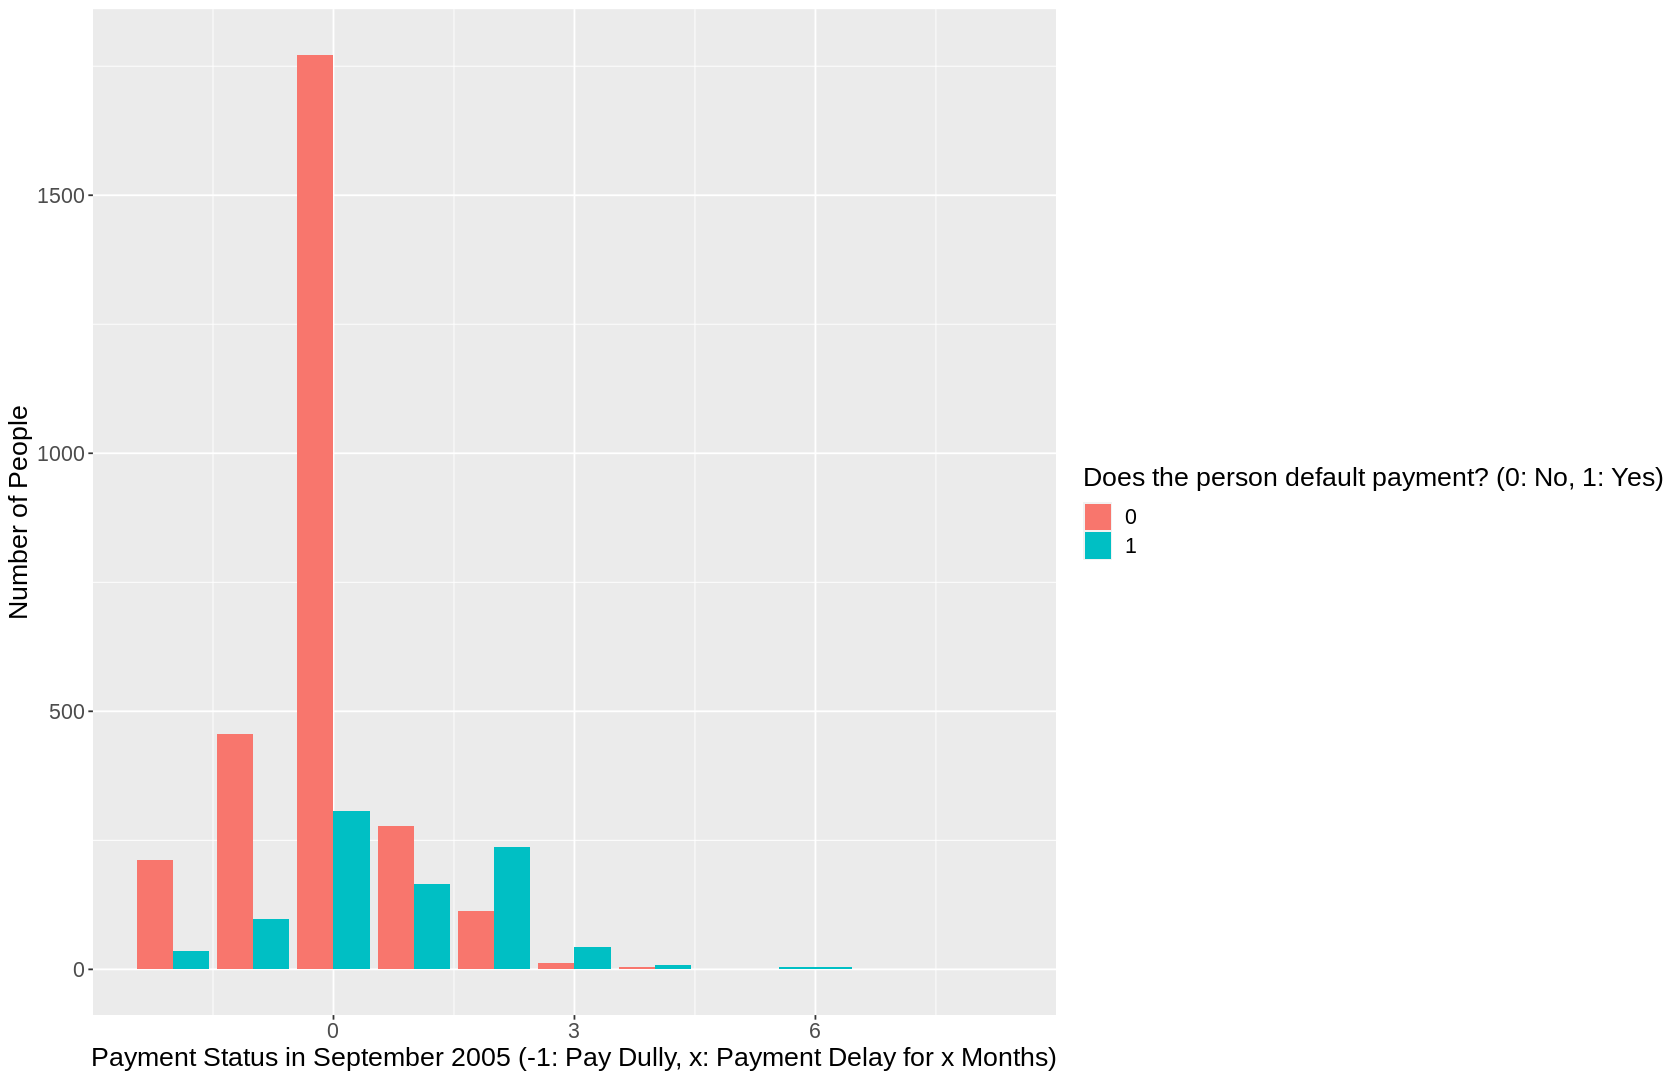

In [105]:
options(repr.plot.width = 14, repr.plot.height = 9)
bar_plot2 <- cd_5000 %>%
   ggplot(aes(x = PAY_0, fill = default_nm)) + 
   geom_bar(position = 'dodge') + 
   xlab("Payment Status in September 2005 (-1: Pay Dully, x: Payment Delay for x Months)") +
   ylab("Number of People") +
   labs(fill = "Does the person default payment? (0: No, 1: Yes)")+
   theme(text = element_text(size = 16))
bar_plot2

Warning message:
“position_stack requires non-overlapping x intervals”


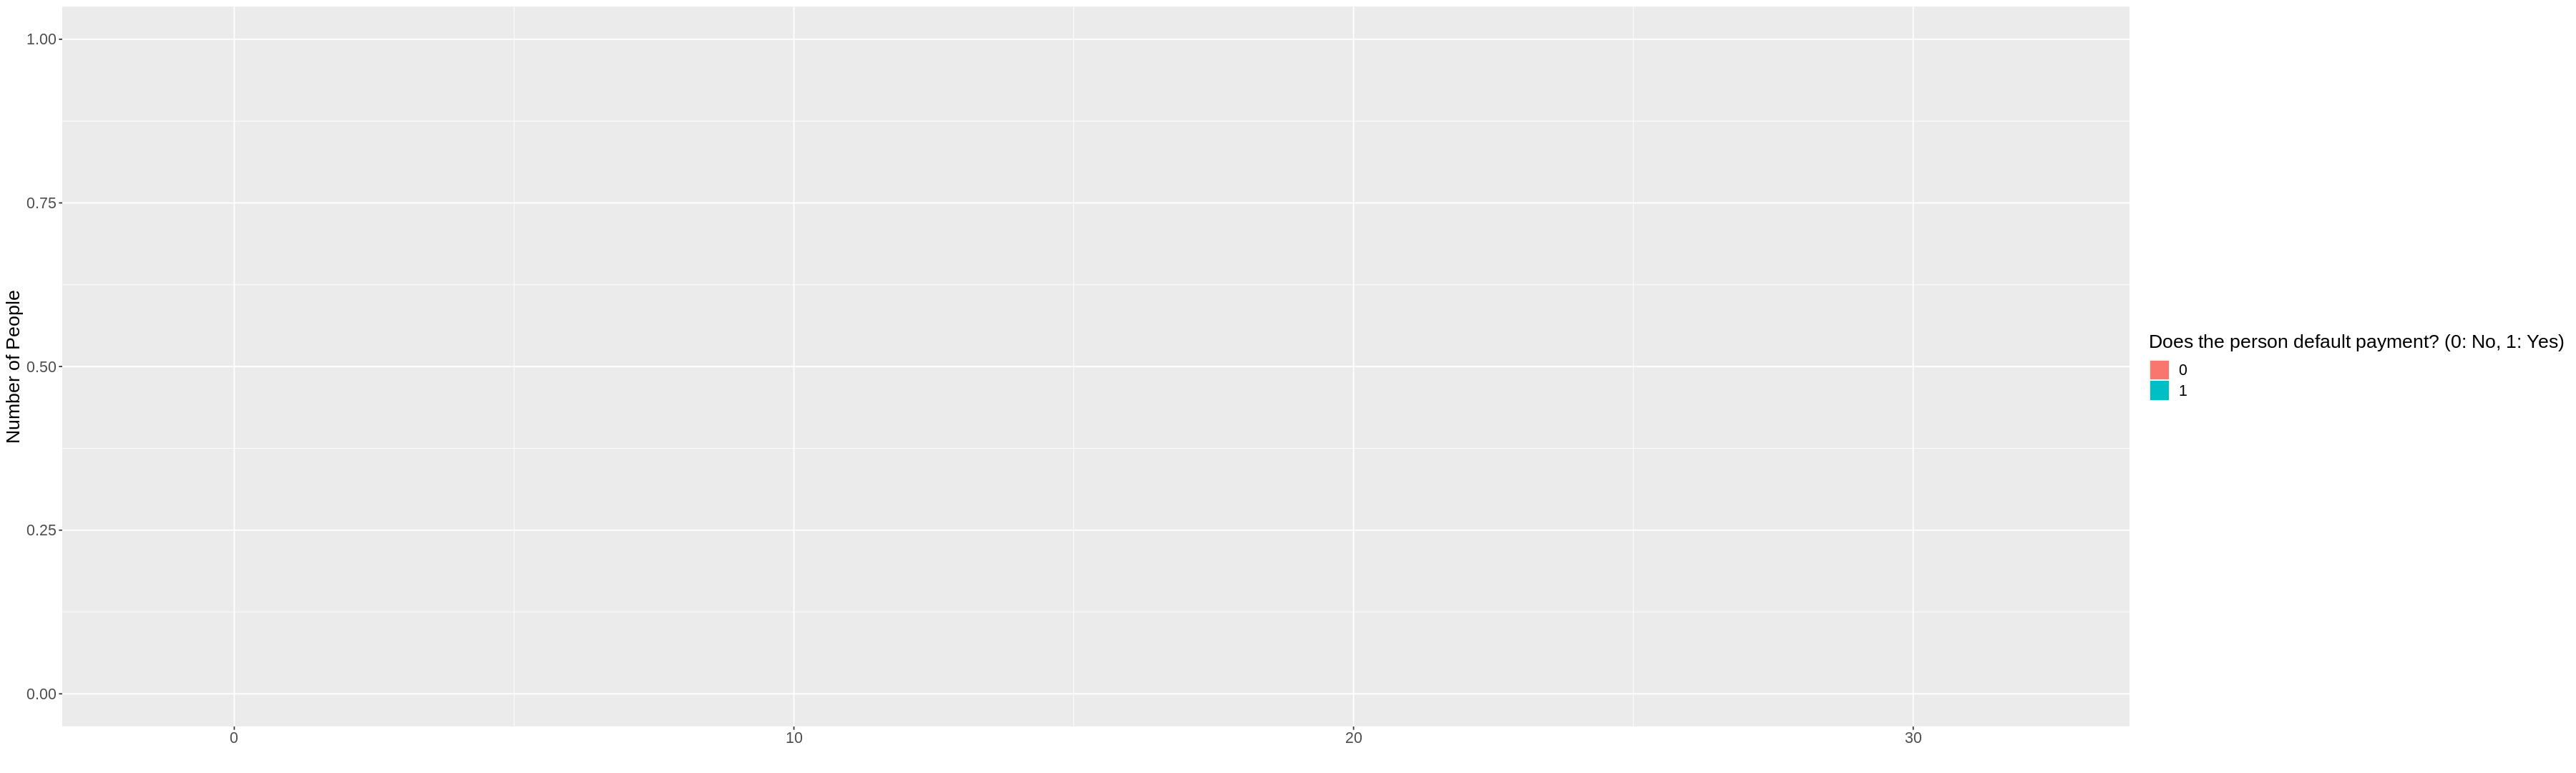

In [97]:
# options(repr.plot.width = 14, repr.plot.height = 9)
# bar_plot <- cd_5000 %>%
#    ggplot(aes(x = usage_cdt, fill = default_nm)) + 
#    geom_bar(position = 'fill') + 
#    xlab("") +
#    ylab("Number of People") +
#    labs(fill = "Does the person default payment? (0: No, 1: Yes)")+
#    theme(text = element_text(size = 16))
# bar_plot

In [ ]:
d1_mar <- d1 %>%
ggplot(aes(x=MARRIAGE)) +
geom_bar() +
ggtitle("d1_mar")

d0_mar <- d0 %>%
ggplot(aes(x=MARRIAGE)) +
geom_bar() +
ggtitle("d0_mar")

plot_grid(d0_mar, d1_mar)

In [ ]:
d0_pmt_usage <- d0 %>%
ggplot(aes(x=usage_cdt, y=pmt)) +
geom_point(alpha=0.4)

d1_pmt_usage <- d1 %>%
ggplot(aes(x=usage_cdt, y=pmt)) +
geom_point(alpha=0.4)

plot_grid(d0_pmt_usage, d1_pmt_usage, labels= c('d0_pmt_usage', 'd1_pmt_usage'))

In [ ]:
d0_diff <- d0 %>%
ggplot(aes(x=diff_usage_pmt, y=diff_usage_pmt)) +
geom_point(alpha=0.4)
d0_diff

d1_diff <- d1 %>%
ggplot(aes(x=diff_usage_pmt, y=diff_usage_pmt)) +
geom_point(alpha=0.4)
d1_diff

In [5]:
cd_split <- initial_split(cd_5000, prop=0.75, strata=default_nm)
cd_training <- training(cd_split)
cd_testing <- testing(cd_split)

In [ ]:
#cd_model <- glm(default_nm ~ LIMIT_BAL + EDUCATION + MARRIAGE + usage_cdt + pmt, data = cd_training, family = binomial(link="logit"))
#summary(cd_model)

In [ ]:
#cd_predictions <- predict(cd_model, cd_training, type="response")
#head(cd_predictions)

In [ ]:
#cd_predictions2 <- ifelse(cd_predictions > 0.5, 1, 0)
#cd_predictions2

In [6]:
cd_recipe <- recipe(default_nm ~ LIMIT_BAL + usage_cdt + pmt, data = cd_training) %>%
step_scale(all_predictors()) %>%
step_center(all_predictors())

cd_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
set_engine("kknn") %>%
set_mode("classification")


In [7]:
cd_vfold <- vfold_cv(cd_training, v=5, strata= default_nm)

grids <- tibble(neighbors = seq(1, 20))

cd_results <- workflow() %>%
add_recipe(cd_recipe) %>%
add_model(cd_spec) %>%
tune_grid(resamples = cd_vfold, grid=grids) %>%
collect_metrics()
cd_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6867551,5,0.006144948,Model01
1,roc_auc,binary,0.5442490,5,0.007025027,Model01
2,accuracy,binary,0.6870221,5,0.005998287,Model02
2,roc_auc,binary,0.5763019,5,0.007762329,Model02
3,accuracy,binary,0.7355409,5,0.003643711,Model03
3,roc_auc,binary,0.5829332,5,0.007693242,Model03
4,accuracy,binary,0.7355409,5,0.003763711,Model04
4,roc_auc,binary,0.5869189,5,0.004789777,Model04
5,accuracy,binary,0.7462015,5,0.003680992,Model05


In [8]:
accuracies <- cd_results %>%
filter(.metric == 'accuracy')
accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6867551,5,0.006144948,Model01
2,accuracy,binary,0.6870221,5,0.005998287,Model02
3,accuracy,binary,0.7355409,5,0.003643711,Model03
4,accuracy,binary,0.7355409,5,0.003763711,Model04
5,accuracy,binary,0.7462015,5,0.003680992,Model05
6,accuracy,binary,0.7464682,5,0.003674923,Model06
7,accuracy,binary,0.7597972,5,0.003539514,Model07
8,accuracy,binary,0.7587306,5,0.003190616,Model08
9,accuracy,binary,0.7613980,5,0.004326589,Model09


Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 2 row(s) containing missing values (geom_path).”


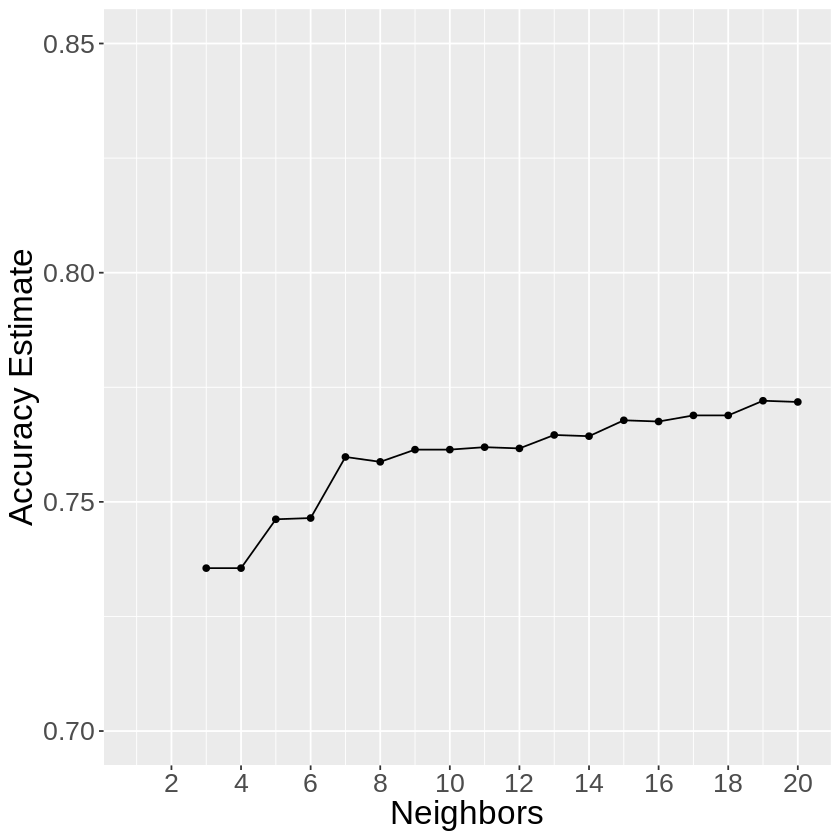

In [9]:
cross_val_plot <- ggplot(accuracies, aes(x=neighbors, y=mean)) +
geom_point() +
geom_line() +
labs(x="Neighbors", y="Accuracy Estimate") +
theme(text = element_text(size = 20)) +
                  scale_x_continuous(breaks = seq(0, 20, 2)) +
                  scale_y_continuous(limits = c(0.7, 0.85))
cross_val_plot